In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from analyze_tools import compute_overlaps, overlapplot

DARK_THEME = False
if DARK_THEME:
    sns.set(style="darkgrid", context="talk")
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})

In [2]:
xstart = "start"
xend = "end"
category = "pair"

df = pd.concat([
    pd.DataFrame({
        xstart: np.arange(0, 100, 50),
        xend: np.arange(10, 110, 50),
        category: "A"
    }),
    pd.DataFrame({
        xstart: np.arange(5, 105, 50),
        xend: np.arange(15, 115, 50),
        category: "A"
    }),
])

df

,start,end,pair
0,0,10,A
1,50,60,A
0,5,15,A
1,55,65,A


## [Figure8]
What if the intervals overlap within the same category?

## [Figure9]
same but with `hue=None` - turns on overlap computation in `overlapplot`

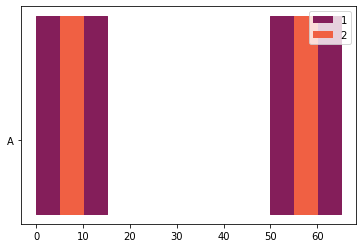

In [3]:
ax = overlapplot(xstart, xend, category, hue=None, data=df)

/Users/tdrozdik/school/asynchronous-duet/duet/analyze_tools.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intervals["xrange"] = df_intervals.apply(


<AxesSubplot:>

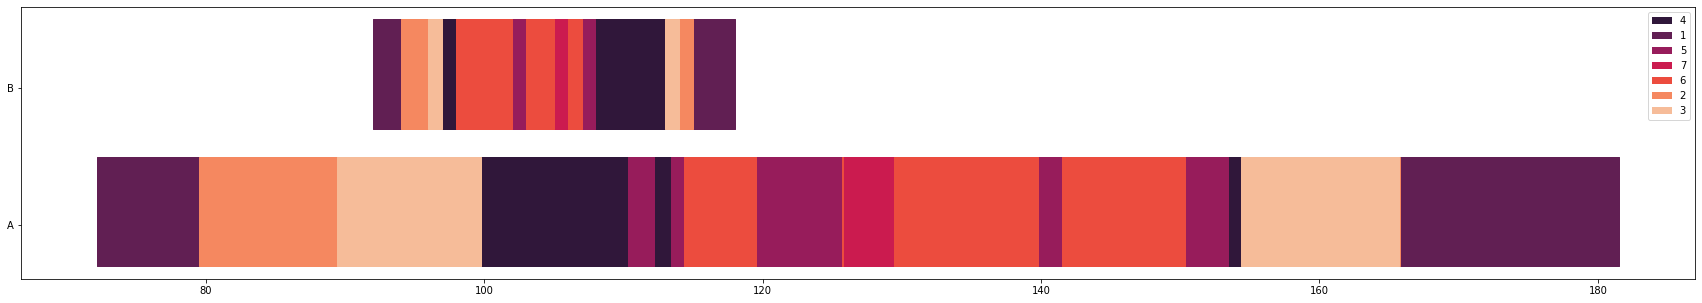

In [4]:
n = 10
a = np.random.normal(100, 20, n)
b = np.random.binomial(200, 0.5, n)
df = pd.concat([
    pd.DataFrame({
        xstart: a,
        xend: a + 40,
        category: "A",
    }, index=np.arange(0, n)),
    pd.DataFrame({
        xstart: b,
        xend: b + 10,
        category: "B",
    }, index=np.arange(0, n)),
])

df = df[df[xstart] < df[xend]]

plt.figure(figsize=(30,5))
overlapplot(xstart, xend, category, data=df)

In [12]:
def overlaps(df, start, end, cat):
    df_overlaps = df.melt(id_vars=[cat], var_name="type", value_vars=[start, end], value_name="time",)
    df_overlaps["value"] = np.select(
        [df_overlaps["type"] == start, df_overlaps["type"] == end], [1, -1]
    )
    df_overlaps["overlaps"] = (
        df_overlaps.sort_values(by=[cat, "time"])
        .groupby(cat)["value"]
        .cumsum()
    )
    df_overlaps[start] = df_overlaps["time"]
    df_overlaps[end] = (
        df_overlaps.sort_values(by=[cat, "time"])
        .groupby(cat)["time"]
        .shift(-1, fill_value=None)
    )

    df_overlaps.dropna(inplace=True)
    df_overlaps.drop(
        df_overlaps[df_overlaps["overlaps"] == 0].index, inplace=True
    )
    return df_overlaps

df_overlaps = overlaps(df, xstart, xend, category)
df_overlaps.head()

,pair,type,time,value,overlaps,start,end
0,A,start,99.773961,1,4,99.773961,110.309980
1,A,start,72.210099,1,1,72.210099,79.554637
2,A,start,110.309980,1,5,110.309980,112.210099
3,A,start,125.796910,1,7,125.796910,129.440007
4,A,start,114.331274,1,6,114.331274,119.554637


## [Figure10]

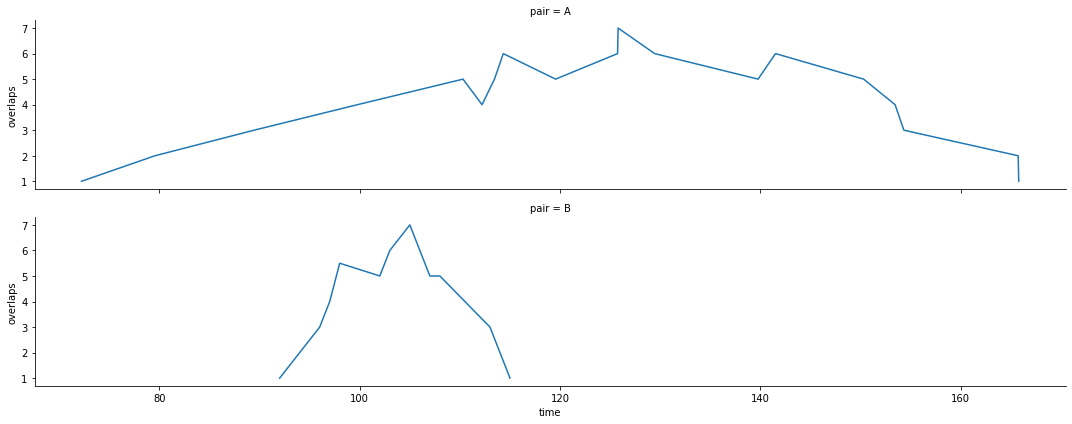

In [11]:
g = sns.FacetGrid(df_overlaps, row=category, aspect=5)
g.map_dataframe(sns.lineplot, x="time", y="overlaps", ci=None)
plt.show()